In [1]:
from pathlib import Path
from datasets import load_dataset, load_metric, concatenate_datasets
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from typing import List
# from tqdm.notebook import tqdm
from tqdm import tqdm
from train import summarization_name_mapping, concatenate_sequence
import pandas as pd
from collections import Counter
import multiprocessing
import time
import math

import seaborn as sns; sns.set_theme(color_codes=True)

from somajo import SoMaJo # sota tokenizer for de - faster than spacy
tokenizer = SoMaJo("de_CMC", split_camel_case=True)

# import spacy
# nlp = spacy.load('de_core_news_sm')
# nlp.disable_pipes('ner', 'lemmatizer', 'morphologizer', 'attribute_ruler', 'tok2vec')
# print(nlp.pipe_names)

# metric
rouge = load_metric("rouge")

local_dataset_name = 'twenty_min_datasets.py'

print(f'tasks: {summarization_name_mapping[local_dataset_name].keys()}')

# stats_df = './data/20min/splits_220512/20min/20_min_0_00_001/stats_all.pkl'
stats_df = './data/20min/splits_220512/20min/20_min_0_00_001/stats_filt.pkl'

tasks: dict_keys(['title_generation', 'lead_generation', 'summary_generation', 'caption_generation', 'category_prediction', 'reading_time_prediction'])


In [2]:
# dataset = load_dataset(local_dataset_name, name='lead_generation')
# print(dataset)

In [5]:
def tokenize(texts: List):
    for text in texts:
        if not isinstance(text, list):
            sentences = tokenizer.tokenize_text([text])
        else:
            sentences = tokenizer.tokenize_text(text)
        yield list(sentences)

def compute_unique_ngrams(src_doc, tgt_doc, n=1):
    uniq_src_ngrams = set(get_ngrams(src_doc, n=n))
    uniq_tgt_ngrams = set(get_ngrams(tgt_doc, n=n))
    if len(uniq_tgt_ngrams) > 0:
        percentage_novelty_ngrams = len(uniq_tgt_ngrams - uniq_src_ngrams) / len(uniq_tgt_ngrams) * 100
    else:
        percentage_novelty_ngrams = 0
    return percentage_novelty_ngrams        

def get_ngrams(text: List[str], n: int = 1):
    text_tokens = [tok.text for sent in text for tok in sent]
    return [' '.join(text_tokens[i:i+n]) for i in range(len(text_tokens)-n+1)]

def compute_src_tgt_rouge(src_doc, tgt_doc, rouge_types=["rougeL"]):
    if isinstance(src_doc, list):
        references = [' '.join(tok.text for sent in src_doc for tok in sent)]
    else:
        references = [' '.join(tok.text for tok in src_doc)]
    
    if isinstance(tgt_doc, list):
        predictions = [' '.join(tok.text for sent in tgt_doc for tok in sent)]
    else:
        predictions = [' '.join(tok.text for tok in tgt_doc)]
        
    scores = rouge.compute(
        predictions=predictions, 
        references=references,
        use_stemmer=True,
        rouge_types=rouge_types,
    )
    # return fmeasure of AggregrateScore (for single texts it's the same for high/mid/low)
    return scores[rouge_types[0]][0].fmeasure

def get_sent_and_token_counts(text):
    s_count = 0
    t_count = 0
    for sentence in text:
        s_count += 1
        t_count += len(sentence) #len([tok.text for tok in sentence])
    return s_count, t_count

def compute_values_distribution(tgts):
    c = Counter()
    if isinstance(tgts[0], list):
        for text in tgts:
#             print(text)
            c.update(text)
    else:
        c.update(tgts)
    return c
    
def compute_summarise_stats(src_docs, tgt_docs):
    print(f'computing stats with {len(src_docs)} items')
    assert len(src_docs) == len(tgt_docs)
    
    stat_data = {
        'tokens_src': np.zeros(len(src_docs)),
        'tokens_tgt': np.zeros(len(tgt_docs)),
        'sents_src': np.zeros(len(src_docs)),
        'sents_tgt': np.zeros(len(tgt_docs)),
#         'rougeL_f1': np.zeros(len(src_docs)),
        'unigrams': np.zeros(len(src_docs)),
        'bigrams': np.zeros(len(src_docs)),
        'trigrams': np.zeros(len(src_docs)),
        'content_items': np.zeros(len(src_docs)),
        'compression': np.zeros(len(src_docs)),
    }

    for i, (src_tok, tgt_tok) in tqdm(enumerate(zip(tokenize(src_docs), tokenize(tgt_docs)))):

        stat_data['sents_src'][i], stat_data['tokens_src'][i] = get_sent_and_token_counts(src_tok)
        stat_data['sents_tgt'][i], stat_data['tokens_tgt'][i] = get_sent_and_token_counts(tgt_tok)
#         stat_data['rougeL_f1'][i] = compute_src_tgt_rouge(src_tok, tgt_tok)
        stat_data['unigrams'][i] = compute_unique_ngrams(src_tok, tgt_tok, n=1)
        stat_data['bigrams'][i] = compute_unique_ngrams(src_tok, tgt_tok, n=2)
        stat_data['trigrams'][i] = compute_unique_ngrams(src_tok, tgt_tok, n=3)
        stat_data['compression'][i] = stat_data['tokens_tgt'][i] / stat_data['tokens_src'][i]
        
        if isinstance(tgt_docs[i], list):
            stat_data['content_items'][i] = len(tgt_docs[i])
        else:
            stat_data['content_items'][i] = 1

    
    for k in list(stat_data.keys()):
        stat_data[k] = stat_data[k].mean()
    
    return stat_data

def preprocess_function(examples, text_column, summary_column):
    """ 
    adapted from custom preprocess function defined in train_local_20min_simplification.py.
    """
#     inputs, targets = [], []
#     if isinstance(examples[summary_column][0], list) and summary_column != 'category':
#         print('summary_column is a list - concatenating content...')
#         for i in range(len(examples[summary_column])):
#             if examples[text_column][i] is not None and examples[summary_column][i] is not None:
#                 inputs.append(examples[text_column][i])
#                 targets.append(concatenate_sequence(examples[summary_column][i], split_char='• '))
#     else:
    inputs = examples[text_column]
    targets = examples[summary_column]
    
    assert len(inputs) == len(targets)
    
    return inputs, targets

def build_stats_df():
    stat_data = {}
    debug = False
    for task_name in summarization_name_mapping[local_dataset_name].keys():
        dataset = load_dataset(local_dataset_name, name=task_name)
        text_column, summary_column = summarization_name_mapping.get(local_dataset_name, None).get(task_name)        

        print(f'*** {task_name} ***')
        stat_data[task_name] = {}

        task_src_texts = []
        task_tgt_texts = []

        # combine all splits for aggregated stats
        for split in ['train', 'test', 'validation']:
            print(f'{split} has {len(dataset[split])} items')
            stat_data[task_name][split] = len(dataset[split])
            if debug:
                max_samples = 50
                src_texts, tgt_texts = preprocess_function(dataset[split].select(range(max_samples)), text_column, summary_column)
            else:
                src_texts, tgt_texts = preprocess_function(dataset[split], text_column, summary_column)
            task_src_texts += src_texts
            task_tgt_texts += tgt_texts

        print(f'total items available for task {task_name} {len(task_src_texts)} / {len(task_tgt_texts)}')

        stat_data[task_name].update(compute_summarise_stats(task_src_texts, task_tgt_texts))
        print(stat_data)
        print()
        
    df = pd.DataFrame.from_dict(stat_data, orient='index')
    df.to_pickle(stats_df)

    return df
    
def get_count_stats(debug=False):
    count_data = {}
    for task_name in summarization_name_mapping[local_dataset_name].keys():
        print(task_name)
        if task_name in ['reading_time_prediction', 'category_prediction']:
            dataset = load_dataset(local_dataset_name, name=task_name)
            print(dataset)
            text_column, summary_column = summarization_name_mapping.get(local_dataset_name, None).get(task_name)        

            print(f'*** {task_name} ***')
            count_data[task_name] = {}

            for split in ['train', 'test', 'validation']:
                print(f'{split} has {len(dataset[split])} items')
#                 count_data[task_name][split] = len(dataset[split])
                if debug:
                    max_samples = 50
                    src_texts, tgt_texts = preprocess_function(dataset[split].select(range(max_samples)), text_column, summary_column)
                else:
                    src_texts, tgt_texts = preprocess_function(dataset[split], text_column, summary_column)

                count_data[task_name][split] = compute_values_distribution(tgt_texts)
                                   
    return count_data

In [ ]:
# count_data = get_count_stats()


In [6]:
pickled_df = Path(stats_df)
if pickled_df.exists():
    df = pd.read_pickle(str(pickled_df))
else:
    print(f'Dataset stats dataframe not found at {stats_df}. Building...')
    df = build_stats_df()

df

,train,test,validation,tokens_src,tokens_tgt,sents_src,sents_tgt,unigrams,bigrams,trigrams,content_items,compression
title_generation,40886,4505,4536,378.688786,8.025057,20.464178,1.008412,36.716290,79.275881,89.929994,1.000000,0.032815
lead_generation,40905,4508,4537,378.672733,26.155135,20.462863,2.020881,35.380744,77.860953,90.771320,1.000000,0.108290
summary_generation,22659,2696,2707,386.585311,45.388711,20.827952,3.622728,32.625987,71.991345,85.994175,3.456168,0.149625
caption_generation,37232,4105,4096,378.341052,175.382651,20.449431,11.870271,40.188117,67.984953,77.657186,7.866793,0.962901
category_prediction,11005,1297,1319,398.300786,4.147273,21.422363,3.205932,50.999462,84.281831,72.998204,3.205859,0.013198
reading_time_prediction,11416,1386,1396,398.071419,1.000000,21.318777,1.000000,98.915340,0.000000,0.000000,1.000000,0.003322


In [7]:
print(df.to_latex(
    float_format='%.2f', 
    na_rep='--'))

\begin{tabular}{lrrrrrrrrrrrr}
\toprule
{} &  train &  test &  validation &  tokens\_src &  tokens\_tgt &  sents\_src &  sents\_tgt &  unigrams &  bigrams &  trigrams &  content\_items &  compression \\
\midrule
title\_generation        &  40886 &  4505 &        4536 &      378.69 &        8.03 &      20.46 &       1.01 &     36.72 &    79.28 &     89.93 &           1.00 &         0.03 \\
lead\_generation         &  40905 &  4508 &        4537 &      378.67 &       26.16 &      20.46 &       2.02 &     35.38 &    77.86 &     90.77 &           1.00 &         0.11 \\
summary\_generation      &  22659 &  2696 &        2707 &      386.59 &       45.39 &      20.83 &       3.62 &     32.63 &    71.99 &     85.99 &           3.46 &         0.15 \\
caption\_generation      &  37232 &  4105 &        4096 &      378.34 &      175.38 &      20.45 &      11.87 &     40.19 &    67.98 &     77.66 &           7.87 &         0.96 \\
category\_prediction     &  11005 &  1297 &        1319 &      398.3

/net/cephfs/data/tkew/tmp/7777233/ipykernel_940/2613991771.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(


In [22]:

def get_count_stats_with_text_lengths(debug=False, task_name='reading_time_prediction'):
    count_data = {}
    dataset = load_dataset(local_dataset_name, name=task_name)
    text_column, summary_column = summarization_name_mapping.get(local_dataset_name, None).get(task_name)        

    print(f'*** {task_name} ***')
    
    s_counts, t_counts, splits, tgts = [], [], [], []
    w_counts = []
    c_counts = []
    srcs = []
    for split in ['train', 'test', 'validation']:
        print(f'{split} has {len(dataset[split])} items')
        if debug:
            max_samples = 50
            src_texts, tgt_texts = preprocess_function(dataset[split].select(range(max_samples)), text_column, summary_column)
        else:
            src_texts, tgt_texts = preprocess_function(dataset[split], text_column, summary_column)

        for text in src_texts:
            w_counts.append(len(text.split()))
            c_counts.append(len(text))
            srcs.append(text)
            
        for text in tokenize(src_texts):            
            s_count, t_count = get_sent_and_token_counts(text)
            s_counts.append(s_count)
            t_counts.append(t_count)
            splits.append(split)
            
        tgts += tgt_texts
    
    data = {
        'sents': s_counts,
        'toks': t_counts,
        'words': w_counts,
        'chars': c_counts,
        'times': tgts,
        'splits': splits, 
        'src': srcs,
        'tgt': tgts
    }

    df = pd.DataFrame.from_dict(data, orient='columns')
    df['times'] = pd.to_numeric(df['times'])
    
    return df

In [20]:
# df = get_count_stats_with_text_lengths(debug=False)
# print(df.info())
# vals = df['times'].value_counts()
# vals = list(range(min(vals), max(vals), 60))
# # print(vals)

[60, 120, 180, 240]
[0, 60, 120, 180, 240, 300]
[60, 120, 180, 240]
[0, 60, 120, 180, 240, 300]
[60, 120, 180, 240]
[0, 60, 120, 180, 240, 300]
[60, 120, 180, 240]
[0, 60, 120, 180, 240, 300]


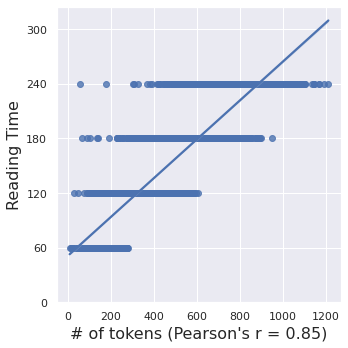

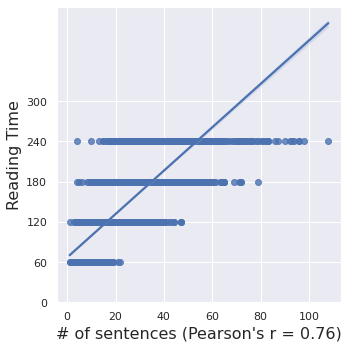

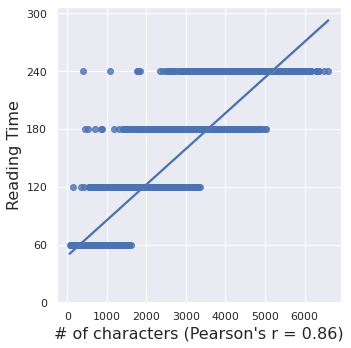

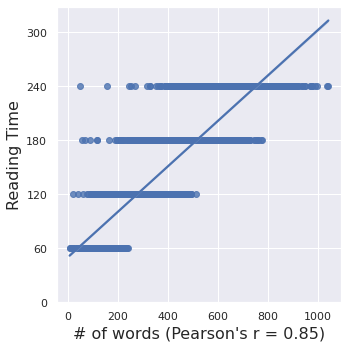

In [40]:
def plot_reading_time_correlations(df, columns=['toks'], remove_outliers=False, save_as=None):
    
    fig, axes = plt.subplots(nrows=1, ncols=len(columns), sharex=False, sharey=True, 
                             figsize=(5*len(columns), 5), tight_layout=True)
    
    if remove_outliers:
        df = df[(np.abs(stats.zscore(df['times'])) < 3)]
#     print(df.info())

    times = list(sorted(df['times'].unique()))
    print(times)
    times = [0] + times + [times[-1]+60]
    print(times)
    
    fs = 16
    
    for i, col in enumerate(columns):
    
        corr = df[col].corr(df['times'])
        
        ax = sns.regplot(x=col, y="times", data=df)
        
        if col == 'toks':
            ax.set_xlabel(f'# of tokens (Pearson\'s r = {corr:.2f})', fontsize=fs)          
#             ax.set_title('Relationsheading times and  Estimated Reading Times', fontsize=fs*1.2)
        elif col == 'sents':
            ax.set_xlabel(f'# of sentences (Pearson\'s r = {corr:.2f})', fontsize=fs)
        elif col == 'words':
            ax.set_xlabel(f'# of words (Pearson\'s r = {corr:.2f})', fontsize=fs)
        elif col == 'chars':
            ax.set_xlabel(f'# of characters (Pearson\'s r = {corr:.2f})', fontsize=fs)

        ax.set_yticks(times, fontsize=fs*0.8)
#         ax.set_ylim(bottom=0, top=720)
        
        if i == 0:
            ax.set_ylabel('Reading Time', fontsize=fs)
        else:
            ax.set_ylabel(None)

        
            
    if save_as:
        fig.savefig(save_as)

    return

plot_reading_time_correlations(df, columns=['toks'], remove_outliers=True, save_as='./plots/reading_time_toks_corr.png')
plot_reading_time_correlations(df, columns=['sents'], remove_outliers=True, save_as='./plots/reading_time_sents_corr.png')
plot_reading_time_correlations(df, columns=['chars'], remove_outliers=True, save_as='./plots/reading_time_chars_corr.png')
plot_reading_time_correlations(df, columns=['words'], remove_outliers=True, save_as='./plots/reading_time_words_corr.png')

In [30]:
vals = df['times'].unique()
vals

array([  60,  120,  180,  240,  300,  360,  480,  540,  420, 1080,  720,
        600])

In [37]:
for i, row in df.iterrows():
    if row['sents'] < 3 and row['times']:
        print(row['splits'], row['src'], row['times'])

train Torhüter Innenverteidiger Aussenverteidiger Zentrales Mittelfeld Flügelspieler Stürmer  60
train Nach einem Fussballspiel der Serie A in Italien ist eine Journalistin vor laufender Kamera sexuell belästigt worden. Wie auf Aufzeichnungen der Szene vom Samstagabend zu sehen ist, griff ein Mann Greta Beccaglia von Toscana TV nach dem 2:1 des FC Empoli gegen AC Florenz im Vorbeilaufen an den Hintern.  60
train Billie Eilish «Male Fantasy» Halsey «People Disappear Here»  60
train Lade hier deine Bilder hoch. Die anderen Bilder der Leserinnen und Leser findest du hier.  60
train Lade hier deine Bilder hoch. Die anderen Bilder der Leserinnen und Leser findest du hier.  60
train Die anderen Bilder der Leserinnen und Leser findest du hier. Lade hier deine Bilder hoch.  60
train Lade hier deine Bilder hoch. Die anderen Bilder der Leserinnen und Leser findest du hier.  60
train Die anderen Bilder der Leserinnen und Leser findest du hier. Lade hier deine Bilder hoch.  60
train Die anderen Bi

14202
120     7814
180     3577
60      1857
240      763
300      130
360       37
420       14
480        5
540        2
1080       1
720        1
600        1
Name: times, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 14011 entries, 0 to 14201
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   sents   14011 non-null  int64 
 1   toks    14011 non-null  int64 
 2   words   14011 non-null  int64 
 3   chars   14011 non-null  int64 
 4   times   14011 non-null  int64 
 5   splits  14011 non-null  object
dtypes: int64(5), object(1)
memory usage: 766.2+ KB
None
[763, 823, 883, 943, 1003, 1063, 1123, 1183, 1243, 1303, 1363, 1423, 1483, 1543, 1603, 1663, 1723, 1783, 1843, 1903, 1963, 2023, 2083, 2143, 2203, 2263, 2323, 2383, 2443, 2503, 2563, 2623, 2683, 2743, 2803, 2863, 2923, 2983, 3043, 3103, 3163, 3223, 3283, 3343, 3403, 3463, 3523, 3583, 3643, 3703, 3763, 3823, 3883, 3943, 4003, 4063, 4123, 4183, 4243, 4303, 43

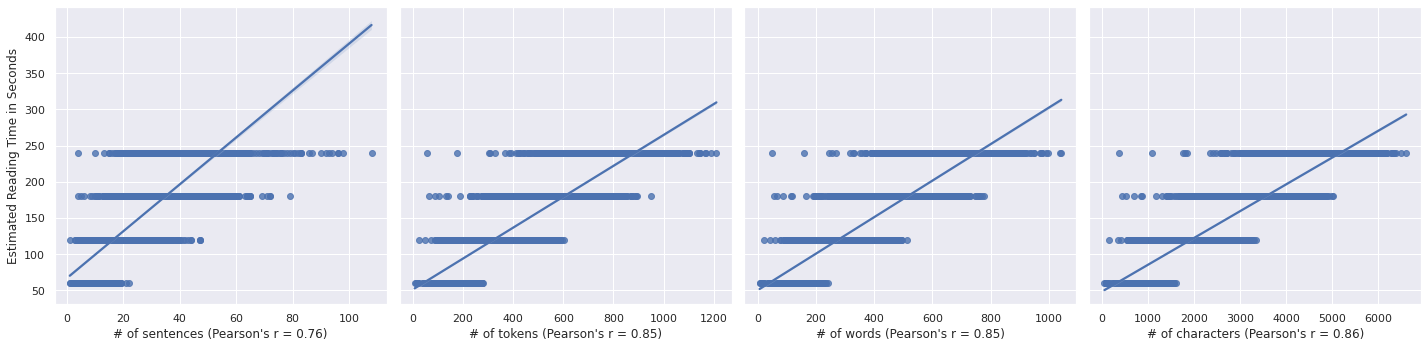

In [8]:
# # remove outliers and recompute...

# print(len(df))
# print(df['times'].value_counts())
# df = df[(np.abs(stats.zscore(df['times'])) < 3)]
# print(df.info())
# vals = df['times'].value_counts()
# vals = list(range(min(vals), max(vals), 60))
# print(vals)

# tok_corr = df['toks'].corr(df['times'])
# sent_corr = df['sents'].corr(df['times'])
# word_corr = df['words'].corr(df['times'])
# char_corr = df['chars'].corr(df['times'])

# fig, axes = plt.subplots(nrows=1, ncols=4, sharex=False, sharey=True, figsize=(20, 5), tight_layout=True)

# ax1 = sns.regplot(x="sents", y="times", data=df, ax=axes[0])
# ax2 = sns.regplot(x="toks", y="times", data=df, ax=axes[1])
# ax3 = sns.regplot(x="words", y="times", data=df, ax=axes[2])
# ax4 = sns.regplot(x="chars", y="times", data=df, ax=axes[3])

# ax1.set_ylabel('Estimated Reading Time in Seconds')
# ax1.set_xlabel(f'# of sentences (Pearson\'s r = {sent_corr:.2f})')

# ax2.set_ylabel(None)
# ax2.set_xlabel(f'# of tokens (Pearson\'s r = {tok_corr:.2f})')

# ax3.set_ylabel(None)
# ax3.set_xlabel(f'# of words (Pearson\'s r = {word_corr:.2f})')

# ax4.set_ylabel(None)
# ax4.set_xlabel(f'# of characters (Pearson\'s r = {char_corr:.2f})')


# fig.savefig('./plots/reading_time_correlations_wo_outliers.png')


openness = 1 − √(2 × CT )/(CR + CE) (2) 

where: 
- CT = number of classes used for training 
- CR = number of classes to be recognized, i.e. target classes (total)
- CE = number of classes used during evaluation/testing

defined by Scheirer (2013) and reported in Prakhya et al. (2017).

<!-- NOTE: since the number of training topics far outweighs the number of test topics, to get a positive value for openness (as defined by Scheirer), we need to provide the difference of the train/test labels as the number of training classes. -->

In [6]:
# train = set(count_data['category_prediction']['train'].keys())
# test = set(count_data['category_prediction']['test'].keys())
# dev = set(count_data['category_prediction']['validation'].keys())

# print(len(train))
# print(len(test))
# print(len(test.difference(train)))

# def compute_openness(ct, cr, ce):
#     numer = 2 * ct
#     denom = cr + ce
# #     print(numer, denom)
#     x = math.sqrt(numer/denom)
# #     print(x)
#     return 1 - x 

# print(compute_openness(12, 88, 88)) # from Scheirer (2013)
# print(compute_openness(6, 88, 88)) # from Scheirer (2013)
# # print(compute_openness(2724, 96, 1108+96))
# # print(compute_openness(len(train.difference(test)), len(test.union(train)), len(test)))
# # print(compute_openness(len(train - test), len(test | train), len(test)))

2724
1108
96
0.6307255270620018
0.7388835160664533


In [8]:
c = count_data['category_prediction']['train']
# print(c.most_common(50))
c = count_data['category_prediction']['train'] + count_data['category_prediction']['test'] + count_data['category_prediction']['validation']
cdf = pd.DataFrame(c.most_common(50))
print(cdf.to_latex(index=False))


\begin{tabular}{lr}
\toprule
                    0 &    1 \\
\midrule
          Coronavirus & 2144 \\
           Wirtschaft & 1463 \\
                  USA &  966 \\
              Schweiz &  721 \\
          Deutschland &  582 \\
             Fussball &  579 \\
     Corona-Impfstoff &  403 \\
             Russland &  395 \\
                Sport &  370 \\
               Unfall &  369 \\
        Ukraine-Krieg &  326 \\
                 Geld &  320 \\
            Todesfall &  283 \\
                Musik &  256 \\
               Impfen &  252 \\
            Instagram &  240 \\
                 News &  239 \\
         Social Media &  225 \\
           Gesundheit &  222 \\
         Detailhandel &  222 \\
      Grossbritannien &  220 \\
       Kantonspolizei &  217 \\
         Showbusiness &  211 \\
              Italien &  210 \\
                Liebe &  209 \\
           Frankreich &  208 \\
         Kriminalität &  207 \\
               Kinder &  207 \\
                   TV &  203 \\
  

/tmp/ipykernel_22880/3778759230.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(cdf.to_latex(index=False))


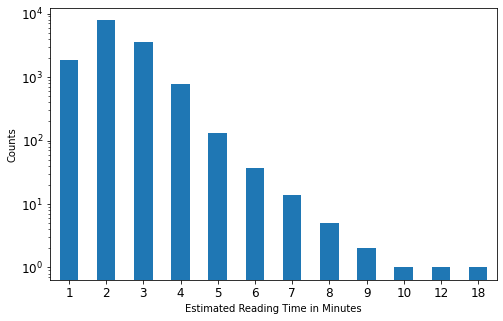

In [40]:
# c = count_data['reading_time_prediction']['train']
# print(c.most_common())
# c = count_data['reading_time_prediction']['train'] + count_data['reading_time_prediction']['test'] + count_data['reading_time_prediction']['validation']
# tdf = pd.DataFrame.from_dict(dict({int(int(k)/60): c[k] for k in c.keys()}), orient='index').sort_index()
# tdf
# fig = tdf.plot(kind='bar', figsize=(8, 5), fontsize=12, logy=True, legend=False, rot=0, ylabel='Counts', xlabel='Estimated Reading Time in Minutes').get_figure()
# fig.savefig('./plots/reading_time_dist.png')



In [131]:
# df['train / test / valid'] = df.apply(lambda x: f'{int(x.train)} / {int(x.test)} / {int(x.validation)}', axis=1)
# df['avg. tokens src / tgt'] = df.apply(lambda x: f'{int(x.tokens_src)} / {int(x.tokens_tgt)}', axis=1)
# df['avg. sents src / tgt'] = df.apply(lambda x: f'{int(x.sents_src)} / {int(x.sents_tgt)}', axis=1)
# df['\% novel 1- / 2- / 3-grams'] = df.apply(lambda x: f'{int(x.unigrams)} / {int(x.bigrams)} / {int(x.trigrams)}', axis=1)
# df
# print(df.to_latex(
#     columns=[
#         'train / test / valid',
#         'avg. tokens src / tgt',
#         'avg. sents src / tgt',
#         '\% novel 1- / 2- / 3-grams',
#         'content_items',
#         'compression'
#         ], 
#     float_format='%.2f', 
#     na_rep='--'))

In [132]:
# print(df.drop(columns=['count_data']).to_latex(float_format='%.2f', na_rep='--'))

In [134]:
# cls_task_df = df[~df['count_data'].isna()]
# cls_task_df
# print(cls_task_df.to_latex(columns=['train', 'test', 'validation'], float_format='%.2f', na_rep='--'))

In [10]:
# # testing on individual tasks

# local_dataset_task_name = 'lead_generation_task'
# # local_dataset_task_name = 'summary_generation_task'
# # local_dataset_task_name = 'reading_time_task'
# # local_dataset_task_name = 'caption_generation_task'
# # local_dataset_task_name = 'category_task'


# dataset = load_dataset(
#     local_dataset_name, name=local_dataset_task_name
#     )
# text_column, summary_column = summarization_name_mapping.get(local_dataset_name, None).get(local_dataset_task_name)
# max_samples = 100
# dataset = dataset['test'].select(range(max_samples))
# # dataset = dataset['test'] 
# src_texts, tgt_texts = preprocess_function(dataset, text_column, summary_column)
# # for testing, use head 100
# print(src_texts[:1])
# print(tgt_texts[:1])

# print(compute_summarise_stats(src_texts, tgt_texts))
# # print(compute_values_distribution(tgt_texts))
